In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py

from keras import callbacks 
from keras.constraints import maxnorm
from keras.models import Sequential
from keras.layers import Dense

from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten
import keras

In [2]:
img=np.load('train_image.npy')
img.shape

(2378, 768, 768)

In [3]:
#Data preprocessing-----------------------------------------------------------------------------------
#DNN 4 slices, each slice size:64*64
#use 64*64 image to predict 40*40 image

#Create trainset
DNN_train=np.zeros((2375*4,64,64,3))

#1st slice
DNN_train[:2375,:,:,0]=img[:-3][:,:64,:64]
DNN_train[:2375,:,:,1]=img[1:-2][:,:64,:64]
DNN_train[:2375,:,:,2]=img[2:-1][:,:64,:64]

#2nd slice
DNN_train[2375:2375*2,:,:,0]=img[:-3][:,64:128,64:128]
DNN_train[2375:2375*2,:,:,1]=img[1:-2][:,64:128,64:128]
DNN_train[2375:2375*2,:,:,2]=img[2:-1][:,64:128,64:128]

#3rd slice 
DNN_train[2375*2:2375*3,:,:,0]=img[:-3][:,128:192,128:192]
DNN_train[2375*2:2375*3,:,:,1]=img[1:-2][:,128:192,128:192]
DNN_train[2375*2:2375*3,:,:,2]=img[2:-1][:,128:192,128:192]

#4th slice
DNN_train[2375*3:2375*4,:,:,0]=img[:-3][:,192:256,192:256]
DNN_train[2375*3:2375*4,:,:,1]=img[1:-2][:,192:256,192:256]
DNN_train[2375*3:2375*4,:,:,2]=img[2:-1][:,192:256,192:256]


label=np.zeros((2375*4,40*40))
label[:2375]=img[3:][:,12:52,12:52].reshape(2375,40*40)
label[2375:2375*2]=img[3:][:,76:116,76:116].reshape(2375,40*40)
label[2375*2:2375*3]=img[3:][:,140:180,140:180].reshape(2375,40*40)
label[2375*3:2375*4]=img[3:][:,204:244,204:244].reshape(2375,40*40)


In [4]:
label.shape

(9500, 1600)

In [5]:
DNN_train.shape

(9500, 64, 64, 3)

In [6]:
np.save('DNNtrain64.npy',DNN_train)
np.save('DNNtrain_label64.npy',label)

In [7]:
img1=np.load('test_image.npy')
img1.shape

(598, 768, 768)

In [8]:
#Create testset
DNN_test=np.zeros((595*4,64,64,3))

DNN_test[:595,:,:,0]=img1[:-3][:,:64,:64]
DNN_test[:595,:,:,1]=img1[1:-2][:,:64,:64]
DNN_test[:595,:,:,2]=img1[2:-1][:,:64,:64]

DNN_test[595:595*2,:,:,0]=img1[:-3][:,64:128,64:128]
DNN_test[595:595*2,:,:,1]=img1[1:-2][:,64:128,64:128]
DNN_test[595:595*2,:,:,2]=img1[2:-1][:,64:128,64:128]

DNN_test[595*2:595*3,:,:,0]=img1[:-3][:,128:192,128:192]
DNN_test[595*2:595*3,:,:,1]=img1[1:-2][:,128:192,128:192]
DNN_test[595*2:595*3,:,:,2]=img1[2:-1][:,128:192,128:192]

DNN_test[595*3:595*4,:,:,0]=img1[:-3][:,192:256,192:256]
DNN_test[595*3:595*4,:,:,1]=img1[1:-2][:,192:256,192:256]
DNN_test[595*3:595*4,:,:,2]=img1[2:-1][:,192:256,192:256]

label=np.zeros((595*4,40*40))
label[:595]=img1[3:][:,12:52,12:52].reshape(595,40*40)
label[595:595*2]=img1[3:][:,76:116,76:116].reshape(595,40*40)
label[595*2:595*3]=img1[3:][:,140:180,140:180].reshape(595,40*40)
label[595*3:595*4]=img1[3:][:,204:244,204:244].reshape(595,40*40)

In [9]:
label.shape

(2380, 1600)

In [10]:
DNN_test.shape

(2380, 64, 64, 3)

In [11]:
np.save('DNNtest64.npy',DNN_test)
np.save('DNNtest_label64.npy',label)

In [2]:
#Data loading--------------------------------------------------------------------------------------
img=np.load('DNNtrain64.npy')
lb=np.load('DNNtrain_label64.npy')
img.shape #shape of trainset image

(9500, 64, 64, 3)

In [3]:
lb.shape #shape of trainset label

(9500, 1600)

In [4]:
test_img=np.load('DNNtest64.npy')
test_lb=np.load('DNNtest_label64.npy')
test_img.shape #shape of testset image

(2380, 64, 64, 3)

In [5]:
test_lb.shape #shape of testset label

(2380, 1600)

In [6]:
#create DNN model--------------------------------------------------------------------------------------------
with tf.device("cpu:0"):
    def create_model():

        model = Sequential()
        model.add(keras.Input(shape=(64,64,3)))
        model.add(Flatten())
        model.add(Dense(1024,activation='relu'))
        model.add(Dense(4000,activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1024,activation='relu'))
        model.add(Dense(40*40))
        model.summary()
        
        eval_type1 = 'mean_squared_error'
        eval_type2=tf.keras.metrics.RootMeanSquaredError()

        model.compile(loss='mean_squared_error',optimizer='adam',metrics=[eval_type1,eval_type2])
        
        return model

model=create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              12583936  
_________________________________________________________________
dense_1 (Dense)              (None, 4000)              4100000   
_________________________________________________________________
dropout (Dropout)            (None, 4000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              4097024   
_________________________________________________________________
dense_3 (Dense)              (None, 1600)              1640000   
Total params: 22,420,960
Trainable params: 22,420,960
Non-trainable params: 0
____________________________________________

In [7]:
#define batch size and number of epochs 
bsize=20
epch=40

In [9]:
#Train the DNN model----------------------------------------------------------------------------------------
model.fit(img, lb,batch_size = bsize,validation_split=0.1, epochs=epch)

Epoch 1/40
428/428 [==============================] - 5s 9ms/step - loss: 30.2499 - mean_squared_error: 30.2499 - root_mean_squared_error: 4.7878 - val_loss: 6.4031 - val_mean_squared_error: 6.4031 - val_root_mean_squared_error: 2.5304
Epoch 2/40
428/428 [==============================] - 3s 7ms/step - loss: 5.4556 - mean_squared_error: 5.4556 - root_mean_squared_error: 2.3353 - val_loss: 5.8420 - val_mean_squared_error: 5.8420 - val_root_mean_squared_error: 2.4170
Epoch 3/40
428/428 [==============================] - 3s 6ms/step - loss: 4.9121 - mean_squared_error: 4.9121 - root_mean_squared_error: 2.2163 - val_loss: 5.7346 - val_mean_squared_error: 5.7346 - val_root_mean_squared_error: 2.3947
Epoch 4/40
428/428 [==============================] - 3s 7ms/step - loss: 4.7531 - mean_squared_error: 4.7531 - root_mean_squared_error: 2.1801 - val_loss: 5.7731 - val_mean_squared_error: 5.7731 - val_root_mean_squared_error: 2.4027
Epoch 5/40
428/428 [==============================] - 3s 7ms/s

Epoch 36/40
428/428 [==============================] - 3s 7ms/step - loss: 4.4359 - mean_squared_error: 4.4359 - root_mean_squared_error: 2.1061 - val_loss: 5.4552 - val_mean_squared_error: 5.4552 - val_root_mean_squared_error: 2.3356
Epoch 37/40
428/428 [==============================] - 3s 7ms/step - loss: 4.4836 - mean_squared_error: 4.4836 - root_mean_squared_error: 2.1174 - val_loss: 5.4927 - val_mean_squared_error: 5.4927 - val_root_mean_squared_error: 2.3437
Epoch 38/40
428/428 [==============================] - 3s 6ms/step - loss: 4.4421 - mean_squared_error: 4.4421 - root_mean_squared_error: 2.1076 - val_loss: 5.4816 - val_mean_squared_error: 5.4816 - val_root_mean_squared_error: 2.3413
Epoch 39/40
428/428 [==============================] - 3s 7ms/step - loss: 4.5324 - mean_squared_error: 4.5324 - root_mean_squared_error: 2.1289 - val_loss: 5.4599 - val_mean_squared_error: 5.4599 - val_root_mean_squared_error: 2.3366
Epoch 40/40
428/428 [==============================] - 3s 6m

In [10]:
#Evaluate the testset
model.evaluate(test_img, test_lb)

75/75 [==============================] - 0s 3ms/step - loss: 4.8165 - mean_squared_error: 4.8165 - root_mean_squared_error: 2.1946


[4.816471576690674, 4.816471576690674, 2.194646120071411]

In [11]:
predictions=model.predict(test_img)


In [12]:
predictions.shape

(2380, 1600)

In [13]:
predictions.shape

(2380, 1600)

In [43]:
#Plot a sample of the prediction--------------------------------------------------------------
a=np.round(predictions[100]).reshape(40,40)

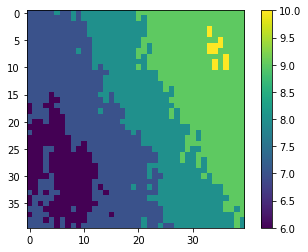

In [44]:
plt.imshow(a)
plt.colorbar()
plt.show()

In [45]:
#Plot the corresponding ground truth--------------------------------------------------------------

b=test_lb[100].reshape(40,40)

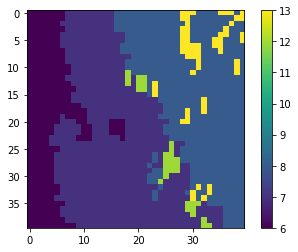

In [46]:
plt.imshow(b)
plt.colorbar()
plt.show()